In [1]:
import sys
sys.path.append("../")

In [21]:
import alphatsp
import alphatsp.tsp
import alphatsp.util

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

In [4]:
import numpy as np

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
def greedy_solver(points, selection_func):
    
    n, d = points.shape
    
    start = np.random.randint(n)
    tour = [start]
    remaining = list(set(range(n)) - set(tour))
    
    while remaining:
        
        next_remaining = selection_func(points, tour, remaining)
        next_node = remaining[next_remaining]
        
        tour.append(next_node)
        remaining = list(set(range(n)) - set(tour))
    
    tour.append(start)
    return tour

In [7]:
def nearest_selection(points, tour, remaining):
    return np.argmin(np.linalg.norm(points[tour[-1]] - points[remaining], ord=2, axis=1))

In [8]:
# generate random pairs of (graph, choice)
def generate_example(n=10, d=2, selection_func=nearest_selection):
    
    points = np.random.rand(n, d)
    iterations = np.random.randint(n-1)
    
    start = np.random.randint(n)
    tour = [start]
    remaining = list(set(range(n)) - set(tour))
    
    it = 0
    while remaining and it < iterations:
        it += 1
        
        next_remaining = selection_func(points, tour, remaining)
        next_node = remaining[next_remaining]
        
        tour.append(next_node)
        remaining = list(set(range(n)) - set(tour))
        
    next_remaining = selection_func(points, tour, remaining)
    next_node = remaining[next_remaining]
    
    label = torch.zeros(len(remaining), dtype=torch.float)
    label[next_remaining] = 1
    
    y = torch.zeros(n, dtype=torch.float)
    y[next_node] = 1
    
    remaining = torch.tensor(sorted(remaining), dtype=torch.long)
    
    edges = torch.zeros((2, len(tour)-1), dtype=torch.long)
    for i in range(len(tour)-1):
        edges[0, i] = tour[i]
        edges[1, i] = tour[i+1]
    
    points = torch.from_numpy(points).to(dtype=torch.float)
    graph = Data(pos=points, edge_index=edges, y=y)
    
    return graph, remaining, label

In [9]:
generate_example()

(Data(edge_index=[2, 1], pos=[10, 2], y=[10]),
 tensor([1, 2, 3, 4, 5, 6, 8, 9]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1.]))

In [10]:
class PolicyNetwork(nn.Module):
    def __init__(self, d=2):
        super(PolicyNetwork, self).__init__()
        self.conv1 = GCNConv(d, 16)
        self.conv2 = GCNConv(16, 1)
    
    def forward(self, graph, choices):
        x, edges = graph.pos, graph.edge_index
        
        x = self.conv1(x, edges)
        x = F.relu(x)
        x = self.conv2(x, edges)
        x = x[choices]
        x = F.softmax(x, dim=0)

        return x

In [11]:
def nn_selection(points, tour, remaining):
    choices = torch.tensor(sorted(remaining), dtype=torch.long)
    edges = torch.zeros((2, len(tour)-1), dtype=torch.long)
    for i in range(len(tour)-1):
        edges[0, i] = tour[i]
        edges[1, i] = tour[i+1]
    points = torch.from_numpy(points).to(dtype=torch.float)
    graph = Data(pos=points, edge_index=edges)
    pred = policy_network(graph, choices)
    pred = torch.argmax(pred.squeeze())
    return pred

In [12]:
policy_network = PolicyNetwork()

In [13]:
optimizer = torch.optim.Adam(params=policy_network.parameters(), lr=0.01)
loss_func = nn.MSELoss()

In [14]:
# training
losses = []
policy_network.train()
for _ in range(5000):
    graph, choices, next_node = generate_example()
    pred = policy_network(graph, choices)
    loss = loss_func(pred, next_node)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

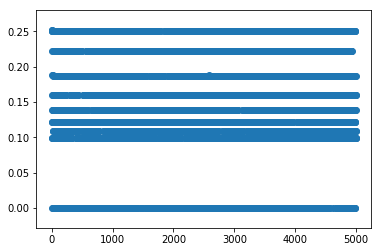

In [15]:
plt.scatter(x=range(len(losses)), y=losses)
plt.show()

In [24]:
# test greedy vs nn
points = np.random.rand(10, 2)
tour_greedy = greedy_solver(points, nearest_selection)
tour_nn = greedy_solver(points, nn_selection)
tsp = alphatsp.tsp.TSP(n=10, d=2, points=points)
tour_greedy_len = tsp.tour_length(tour_greedy)
tour_nn_len = tsp.tour_length(tour_nn)
print("greedy:", tour_greedy_len)
print("nn:", tour_nn_len)

greedy: 3.0505641990507693
nn: 3.361090108608024


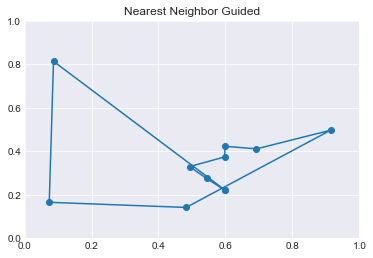

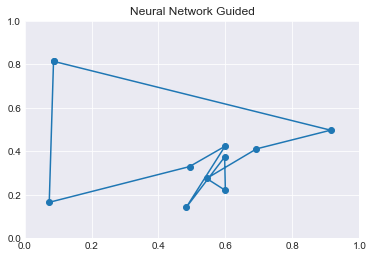

In [25]:
alphatsp.util.display_tour(tsp, tour_greedy, title="Nearest Neighbor Guided")
alphatsp.util.display_tour(tsp, tour_nn, title="Neural Network Guided")